<h1 align="center"><font color=#0000C2>NFL Big Data Bowl 2025</font></h1>
<h2 align="center"> <font color=#800000>Receiver Route Predictor: Data Preparation</font></h2>

The goal of this project is to analyze presnap data to assist defensive coordinators in providing their corners with expectations for what routes the receivers will be running. It is a requirement that the tracking data must be used in the modeling portion. This sheet includes the data preparation, in which the data was read in, feature engineered, cleaned, and prepped for modeling.

Current plans are to attempt both a multinomial regression and a random forest and compare. The goal of this is to determine how accurate of a model I can create, and allow coaches to reap the benefits of providing the defense with route expectations for each of the receivers, running back, and tight ends.

In [1]:
# Import statements
import pandas as pd
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt

Read in data:

In [39]:
games = pd.read_csv('games.csv')
player_info = pd.read_csv('players.csv')
player_action = pd.read_csv('player_play.csv')
play_description = pd.read_csv('plays.csv')

Short Data Frame exploration for ease of manipulation:

In [3]:
#print(f'First five rows of game information: \n{games.head()}')
#print(f'Data Description of player information: \n{games.describe()}')

In [4]:
#print(f'First five rows of player information: \n{player_info.head()}')
#print(f'Data Description of player information: \n{player_info.describe()}')

In [5]:
#print(f'First five rows of player action: \n{player_action.head()}')
#print(f'Data Description of player action: \n{player_action.describe()}')

In [6]:
#print(f'First five rows of play description: \n{play_description.head()}')
#print(f'Data Description of play description: \n{play_description.describe()}')

In [7]:
#print(f'First five rows of player action: \n{player_action.head()}')
#print(f'Data Description of player action: \n{player_action.describe()}')

Create a dataframe of all of the tracking data combined

In [8]:
tracking_files = glob.glob('tracking_week_*.csv')
tracking_data = pd.concat([pd.read_csv(name) for name in tracking_files], ignore_index=True)

In [9]:
# Show how many unique plays there are
unique_plays = tracking_data[['gameId', 'playId']].drop_duplicates()
print(unique_plays.shape[0])

16124


In [40]:
print(tracking_data.head())

       gameId  playId  nflId     displayName  frameId frameType  \
0  2022091200      64  35459  Kareem Jackson      114      SNAP   
1  2022091200      64  39987      Geno Smith      114      SNAP   
2  2022091200      64  41310    Gabe Jackson      114      SNAP   
3  2022091200      64  42393    Ronald Darby      114      SNAP   
4  2022091200      64  42403   Randy Gregory      114      SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-09-13 00:16:14.8          22.0  DEN         right  50.29  29.43  1.13   
1  2022-09-13 00:16:14.8           7.0  SEA         right  37.94  23.86  0.89   
2  2022-09-13 00:16:14.8          66.0  SEA         right  38.52  22.21  0.88   
3  2022-09-13 00:16:14.8          23.0  DEN         right  47.39  13.41  0.25   
4  2022-09-13 00:16:14.8           5.0  DEN         right  40.50  17.63  0.50   

      a   dis       o     dir      event position    x_C    y_C  \
0  1.62  0.11  240.06  133.16  ball_snap   

Feature Engineering to Create a variable that shows the players location relative to the Center:

In [11]:
# Keep only the player locations when the ball is snapped
tracking_data = tracking_data[(tracking_data['frameType']=='SNAP') | (tracking_data['event'] == 'ball_snap')]

In [41]:
print(tracking_data.head())

       gameId  playId  nflId     displayName  frameId frameType  \
0  2022091200      64  35459  Kareem Jackson      114      SNAP   
1  2022091200      64  39987      Geno Smith      114      SNAP   
2  2022091200      64  41310    Gabe Jackson      114      SNAP   
3  2022091200      64  42393    Ronald Darby      114      SNAP   
4  2022091200      64  42403   Randy Gregory      114      SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-09-13 00:16:14.8          22.0  DEN         right  50.29  29.43  1.13   
1  2022-09-13 00:16:14.8           7.0  SEA         right  37.94  23.86  0.89   
2  2022-09-13 00:16:14.8          66.0  SEA         right  38.52  22.21  0.88   
3  2022-09-13 00:16:14.8          23.0  DEN         right  47.39  13.41  0.25   
4  2022-09-13 00:16:14.8           5.0  DEN         right  40.50  17.63  0.50   

      a   dis       o     dir      event position    x_C    y_C  \
0  1.62  0.11  240.06  133.16  ball_snap   

In [13]:
# Add position to create a "distance to center" variable to show where each player lines up
tracking_data = pd.merge(tracking_data, player_info[['position','nflId']], how = 'left', on = 'nflId')

In [14]:
# Add the center position to each row
tracking_data = tracking_data.dropna(subset=['nflId','y','x'])
position_C = tracking_data[tracking_data['position']=='C']
position_C = position_C.rename(columns={'y': 'y_C', 'x':'x_C'})
tracking_data = pd.merge(tracking_data,position_C[['x_C','y_C','gameId','playId']], how='left', on =['gameId','playId'])

In [15]:
tracking_data = tracking_data.dropna(subset=['nflId','y','y_C','x_C'])
print(tracking_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 382272 entries, 0 to 393667
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   gameId         382272 non-null  int64  
 1   playId         382272 non-null  int64  
 2   nflId          382272 non-null  float64
 3   displayName    382272 non-null  object 
 4   frameId        382272 non-null  int64  
 5   frameType      382272 non-null  object 
 6   time           382272 non-null  object 
 7   jerseyNumber   382272 non-null  float64
 8   club           382272 non-null  object 
 9   playDirection  382272 non-null  object 
 10  x              382272 non-null  float64
 11  y              382272 non-null  float64
 12  s              382272 non-null  float64
 13  a              382272 non-null  float64
 14  dis            382272 non-null  float64
 15  o              382272 non-null  float64
 16  dir            382272 non-null  float64
 17  event          382272 non-null  ob

In [16]:
# Create a variable called distanceToCenter to see how far the receivers lineup from the Quarterback
# (Distance to QB was not used in case a play is run without someone with position == 'QB')

tracking_data['distanceToCenter_y'] = tracking_data['y_C'] - tracking_data['y']
tracking_data['distanceToCenter_x'] = tracking_data['x_C'] - tracking_data['x']
tracking_data['nflId'] = tracking_data['nflId'].astype(int)
print(tracking_data.head())

       gameId  playId  nflId     displayName  frameId frameType  \
0  2022091200      64  35459  Kareem Jackson      114      SNAP   
1  2022091200      64  39987      Geno Smith      114      SNAP   
2  2022091200      64  41310    Gabe Jackson      114      SNAP   
3  2022091200      64  42393    Ronald Darby      114      SNAP   
4  2022091200      64  42403   Randy Gregory      114      SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-09-13 00:16:14.8          22.0  DEN         right  50.29  29.43  1.13   
1  2022-09-13 00:16:14.8           7.0  SEA         right  37.94  23.86  0.89   
2  2022-09-13 00:16:14.8          66.0  SEA         right  38.52  22.21  0.88   
3  2022-09-13 00:16:14.8          23.0  DEN         right  47.39  13.41  0.25   
4  2022-09-13 00:16:14.8           5.0  DEN         right  40.50  17.63  0.50   

      a   dis       o     dir      event position    x_C    y_C  \
0  1.62  0.11  240.06  133.16  ball_snap   

In [17]:
# Using left join, insert player position and name into each play
dataframe = pd.merge(player_action, player_info[['position','displayName','nflId']], how = 'left', on = 'nflId')

In [18]:
dataframe = pd.merge(dataframe, play_description, how='left', on = ['gameId', 'playId'])
dataframe = pd.merge(dataframe, games[['gameId', 'week', 'homeTeamAbbr','visitorTeamAbbr']], how = 'left', on = ['gameId'])
dataframe = pd.merge(dataframe, tracking_data[['gameId','playId','nflId','distanceToCenter_x','distanceToCenter_y']], how = 'left', on = ['gameId','playId','nflId'])
print(dataframe.head())
print(dataframe.duplicated(subset=['gameId', 'playId', 'nflId']).sum())

       gameId  playId  nflId teamAbbr  hadRushAttempt  rushingYards  \
0  2022090800      56  35472      BUF               0             0   
1  2022090800      56  35472      BUF               0             0   
2  2022090800      56  42392      BUF               0             0   
3  2022090800      56  42392      BUF               0             0   
4  2022090800      56  42489      BUF               0             0   

   hadDropback  passingYards  sackYardsAsOffense  hadPassReception  \
0            0             0                   0                 0   
1            0             0                   0                 0   
2            0             0                   0                 0   
3            0             0                   0                 0   
4            0             0                   0                 1   

   receivingYards  wasTargettedReceiver  yardageGainedAfterTheCatch  fumbles  \
0               0                     0                           0     

In [19]:
dataframe = dataframe.drop_duplicates(subset=['gameId', 'playId', 'nflId'])

In [20]:
# Shows 22 for each unique combination of game and play Id, meaning there is 1 data point for each of the 22 players
print(dataframe.groupby(['gameId','playId']).size())

print(dataframe.groupby(['gameId','playId','nflId']).size())

gameId      playId
2022090800  56        22
            80        22
            101       22
            122       22
            167       22
                      ..
2022110700  3658      22
            3686      22
            3707      22
            3740      22
            3787      22
Length: 16124, dtype: int64
gameId      playId  nflId
2022090800  56      35472    1
                    38577    1
                    41239    1
                    42392    1
                    42489    1
                            ..
2022110700  3787    53533    1
                    54476    1
                    54541    1
                    54606    1
                    55125    1
Length: 354727, dtype: int64


Further Feature Engineering to find yards to endzone, difference in points, time in the half, and time in the game

In [21]:
# Create a variables that are:
# distance to endzone, score differential, time left in quarter, half, and game
dataframe['yardsToEndzone'] = np.where(dataframe['possessionTeam'] == dataframe['yardlineSide'],100-dataframe['yardlineNumber'],dataframe['yardlineNumber'])
dataframe['scoreDifferential'] = np.where(dataframe['teamAbbr'] == dataframe['homeTeamAbbr'],dataframe['preSnapHomeScore']-dataframe['preSnapVisitorScore'],dataframe['preSnapVisitorScore']-dataframe['preSnapHomeScore'])
dataframe['timeInQuarter'] = pd.to_timedelta('00:' + dataframe['gameClock']).dt.total_seconds().astype(int)
dataframe['timeInHalf'] = np.where(dataframe['quarter']%2 == 1,900+dataframe['timeInQuarter'],dataframe['timeInQuarter'])
dataframe['timeInGame'] = (4 - dataframe['quarter'])*900 + dataframe['timeInQuarter']
print(dataframe[['yardsToEndzone','scoreDifferential','timeInQuarter','timeInHalf', 'timeInGame']])

        yardsToEndzone  scoreDifferential  timeInQuarter  timeInHalf  \
0                   75                  0            900        1800   
2                   75                  0            900        1800   
4                   75                  0            900        1800   
6                   75                  0            900        1800   
8                   75                  0            900        1800   
...                ...                ...            ...         ...   
393662              89                -14             23          23   
393663              89                -14             23          23   
393664              89                -14             23          23   
393665              89                -14             23          23   
393666              89                -14             23          23   

        timeInGame  
0             3600  
2             3600  
4             3600  
6             3600  
8             3600  
...      

In [22]:
dataframe.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,receivingYards,wasTargettedReceiver,yardageGainedAfterTheCatch,fumbles,fumbleLost,fumbleOutOfBounds,assistedTackle,forcedFumbleAsDefense,halfSackYardsAsDefense,passDefensed,quarterbackHit,sackYardsAsDefense,safetyAsDefense,soloTackle,tackleAssist,tackleForALoss,tackleForALossYardage,hadInterception,interceptionYards,fumbleRecoveries,fumbleRecoveryYards,penaltyYards_x,penaltyNames,wasInitialPassRusher,causedPressure,timeToPressureAsPassRusher,getOffTimeAsPassRusher,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,position,displayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,playNullifiedByPenalty,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,playClockAtSnap,passResult,passLength,targetX,targetY,playAction,dropbackType,dropbackDistance,passLocationType,timeToThrow,timeInTackleBox,timeToSack,passTippedAtLine,unblockedPressure,qbSpike,qbKneel,qbSneak,rushLocationType,penaltyYards_y,prePenaltyYardsGained,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,week,homeTeamAbbr,visitorTeamAbbr,distanceToCenter_x,distanceToCenter_y,yardsToEndzone,scoreDifferential,timeInQuarter,timeInHalf,timeInGame
0,2022090800,56,35472,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,G,Rodger Saffold,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,N,85,0.413347,0.586653,1.298699,SHOTGUN,2x2,12.0,C,5.0,80.48,37.68,False,TRADITIONAL,0.99,INSIDE_BOX,2.169,2.169,NaN,False,False,False,0,NaN,NaN,NaN,6,6,-0.000031,0.000031,0.00442,True,NaN,NaN,0,Cover 6-Left,Zone,1,LA,BUF,-0.52,1.53,75,0,900,1800,3600
2,2022090800,56,42392,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,C,Mitch Morse,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,N,85,0.413347,0.586653,1.298699,SHOTGUN,2x2,12.0,C,5.0,80.48,37.68,False,TRADITIONAL,0.99,INSIDE_BOX,2.169,2.169,NaN,False,False,False,0,NaN,NaN,NaN,6,6,-0.000031,0.000031,0.00442,True,NaN,NaN,0,Cover 6-Left,Zone,1,LA,BUF,0.00,0.00,75,0,900,1800,3600
4,2022090800,56,42489,BUF,0,0,0,0,0,1,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,True,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WR,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,N,85,0.413347,0.586653,1.298699,SHOTGUN,2x2,12.0,C,5.0,80.48,37.68,False,TRADITIONAL,0.99,INSIDE_BOX,2.169,2.169,NaN,False,False,False,0,NaN,NaN,NaN,6,6,-0.000031,0.000031,0.00442,True,NaN,NaN,0,Cover 6-Left,Zone,1,LA,BUF,-0.67,-13.98,75,0,900,1800,3600
6,2022090800,56,44875,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,T,Dion Dawkins,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,BUF,25,15:00,0,0,N,85,0.413347,0.586653,1.298699,SHOTGUN,2x2,12.0,C,5.0,80.48,37.68,False,TRADITIONAL,0.99,INSIDE_BOX,2.169,2.169,NaN,False,False,False,0,NaN,NaN,NaN,6,6,-0.000031,0.000031,0.00442,True,NaN,NaN,0,Cover 6-Left,Zone,1,LA,BUF,-0.33,3.32,75,0,900,1800,3600
8,2022090800,56,44985,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,1.0

In [23]:
# Save data frame with all relevant features
dataframe = dataframe[['playId','week','wasRunningRoute','routeRan','position','nflId','quarter','down','yardsToGo','offenseFormation','receiverAlignment','defensiveTeam','possessionTeam','distanceToCenter_x','distanceToCenter_y','yardsToEndzone','scoreDifferential','timeInHalf','timeInGame']]

Final Data Cleaning and send to CSV:

In [24]:
# Remove  all rows where a route was not run
dataframe = dataframe[dataframe['wasRunningRoute']==1]
dataframe = dataframe[dataframe['quarter'] != 5]
dataframe['distanceToCenter_y'] = np.where(dataframe['distanceToCenter_x'] <0,dataframe['distanceToCenter_y'],dataframe['distanceToCenter_y']*-1)
dataframe['distanceToCenter_x'] = np.abs(dataframe['distanceToCenter_x'])
dataframe = dataframe.dropna(subset=['distanceToCenter_x', 'distanceToCenter_y'])

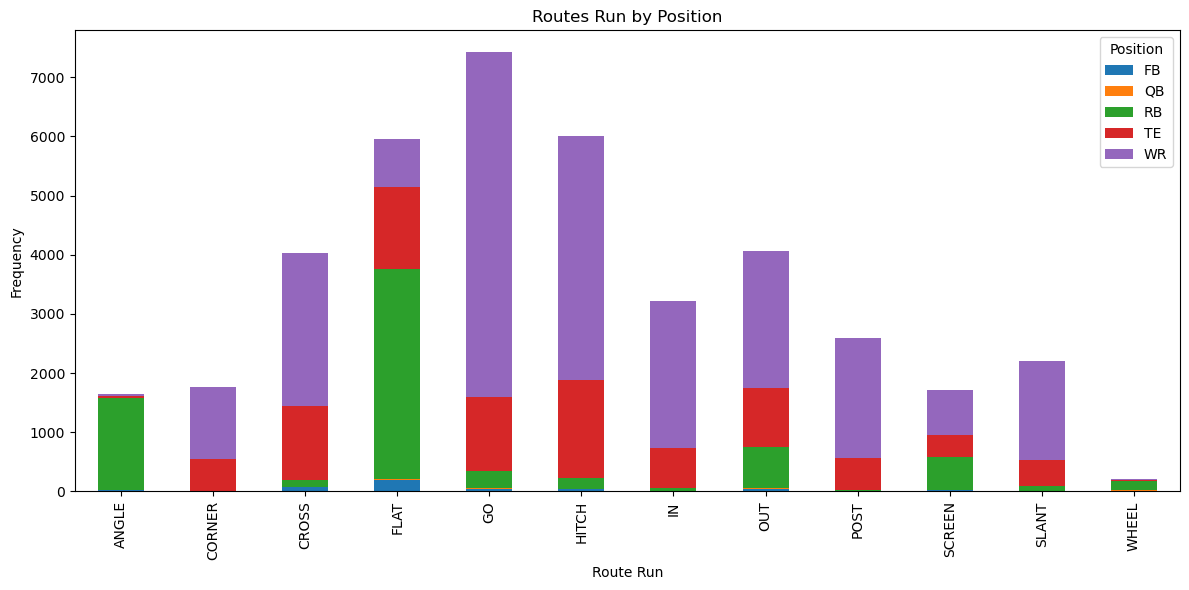

In [37]:
# Create stacked histogram to show which routes are run by each position the most
pivot_data = dataframe.pivot_table(index='routeRan', columns='position', aggfunc='size', fill_value=0)
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Route Run')
plt.ylabel('Frequency')
plt.title('Routes Run by Position')
plt.legend(title='Position')
plt.tight_layout()
plt.show()

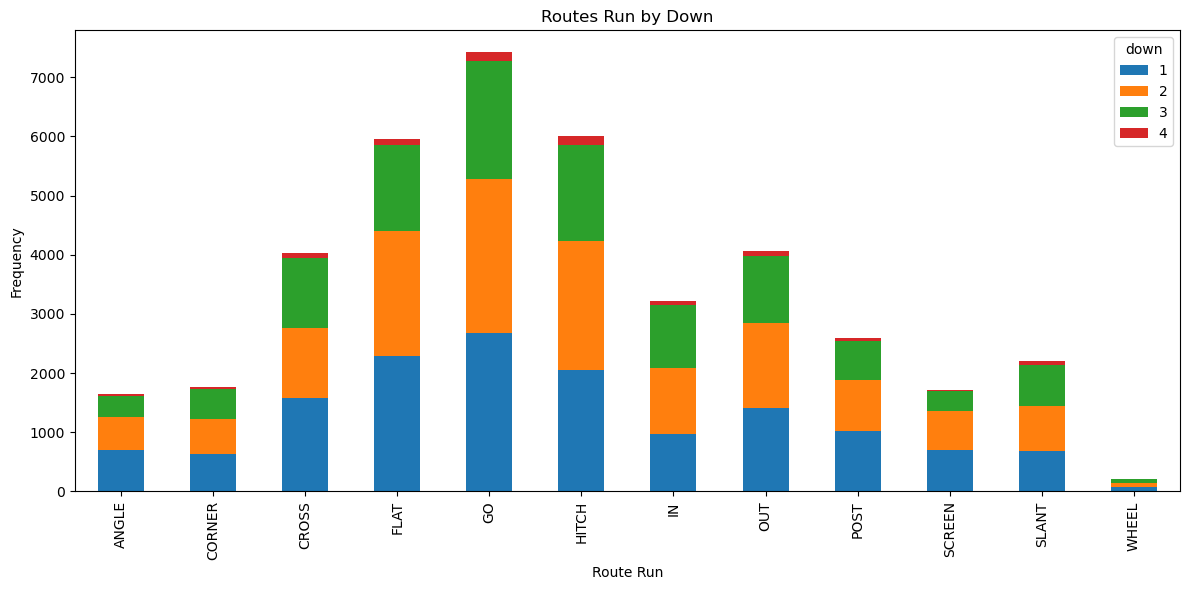

In [38]:
# Create stacked histogram to show which routes are run by each position the most
pivot_data = dataframe.pivot_table(index='routeRan', columns='down', aggfunc='size', fill_value=0)
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Route Run')
plt.ylabel('Frequency')
plt.title('Routes Run by Down')
plt.tight_layout()
plt.show()

It appears that there is not much bias on what route is run vs what down it is, it looks pretty close to perfectly even. Something to consider for future projects is therefore the distance that the receiver "breaks" depending on what down and distance to first it is. It is possible that there is something to be found in that regard.

Position appears to have a large impact on which route is run, with angle and wheel being taken up by running backs, and post and corner having no routes run by running backs.

We can also see that Go, Hitch, and Flat are clearly the most common routes run, which can have impacts on the modeling if it biases towards these and improve accuracy only by estimating these routes.

Final EDA:

In [42]:
dataframe.head()

,playId,week,wasRunningRoute,routeRan,position,nflId,quarter,down,yardsToGo,offenseFormation,receiverAlignment,defensiveTeam,possessionTeam,distanceToCenter_x,distanceToCenter_y,yardsToEndzone,scoreDifferential,timeInHalf,timeInGame
4,56,1,1.0,IN,WR,42489,1,1,10,SHOTGUN,2x2,LA,BUF,0.67,-13.98,75,0,1800,3600
8,56,1,1.0,OUT,WR,44985,1,1,10,SHOTGUN,2x2,LA,BUF,0.69,11.47,75,0,1800,3600
14,56,1,1.0,IN,TE,47879,1,1,10,SHOTGUN,2x2,LA,BUF,0.63,-4.70,75,0,1800,3600
18,56,1,1.0,GO,WR,52536,1,1,10,SHOTGUN,2x2,LA,BUF,0.11,21.42,75,0,1800,3600
136,122,1,1.0,GO,WR,42489,1,2,3,SHOTGUN,2x1,LA,BUF,0.22,-8.31,55,0,1695,3495


In [44]:
dataframe.describe()

,playId,week,wasRunningRoute,nflId,quarter,down,yardsToGo,distanceToCenter_x,distanceToCenter_y,yardsToEndzone,scoreDifferential,timeInHalf,timeInGame
count,40848.000000,40848.000000,40848.0,40848.000000,40848.000000,40848.000000,40848.000000,40848.000000,40848.000000,40848.000000,40848.000000,40848.000000,40848.000000
mean,2013.192127,4.820456,1.0,47989.262118,2.542254,1.951381,8.886726,1.503706,-0.036678,52.125955,-2.702433,809.527345,1730.017945
std,1159.668557,2.567593,0.0,4692.823929,1.111163,0.846009,3.993657,1.693447,10.860448,23.652301,9.234736,554.196052,1042.063480
min,54.000000,1.000000,1.0,30842.000000,1.000000,1.000000,1.000000,0.000000,-24.520000,1.000000,-35.000000,1.000000,1.000000
25%,1023.000000,3.000000,1.0,44849.000000,2.000000,1.000000,6.000000,0.390000,-8.810000,34.000000,-7.000000,286.000000,824.750000
50%,1976.500000,5.000000,1.0,47791.000000,2.000000,2.000000,10.000000,0.900000,-0.080000,56.000000,-3.000000,777.500000,1817.000000
75%,3000.000000,7.000000,1.0,52620.000000,4.000000,3.000000,10.000000,1.630000,8.910000,72.000000,3.000000,1295.000000,2580.000000
max,4545.000000,9.000000,1.0,55168.000000,4.000000,4.000000,38.000000,8.950000,25.610000,99.000000,35.000000,1800.000000,3600.000000


In [45]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40848 entries, 4 to 393193
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   playId              40848 non-null  int64  
 1   week                40848 non-null  int64  
 2   wasRunningRoute     40848 non-null  float64
 3   routeRan            40848 non-null  object 
 4   position            40848 non-null  object 
 5   nflId               40848 non-null  int64  
 6   quarter             40848 non-null  int64  
 7   down                40848 non-null  int64  
 8   yardsToGo           40848 non-null  int64  
 9   offenseFormation    40848 non-null  object 
 10  receiverAlignment   40848 non-null  object 
 11  defensiveTeam       40848 non-null  object 
 12  possessionTeam      40848 non-null  object 
 13  distanceToCenter_x  40848 non-null  float64
 14  distanceToCenter_y  40848 non-null  float64
 15  yardsToEndzone      40848 non-null  int64  
 16  scoreDif

In [26]:
# Send data to csv to be usedin modeling
dataframe.to_csv("preliminary_data.csv")